# Conditional Restricted Boltzmann Machines in R

### CRBM training and testing algorithms, coded in plain R.

Here you can find a Conditional Restricted Boltzmann Machines, implemented in R and in plain algorithm, for academic and educational purposes.

@authors Josep Ll. Berral, David Buchaca (Barcelona Supercomputing Center)

@date 1st December, 2016

### References
* Approach based on <a href="http://www.uoguelph.ca/~gwtaylor/">Graham Taylor</a>'s CRBM: http://www.uoguelph.ca/~gwtaylor/publications/nips2006mhmublv/gwtaylor_nips.pdf

### Mocap data
* R converted version: TODO - Here goes link to motion.rds
* Original file: http://www.uoguelph.ca/~gwtaylor/publications/nips2006mhmublv/motion.mat
* Data originally from Eugene Hsu, MIT. http://people.csail.mit.edu/ehsu/work/sig05stf/

## GENERIC FUNCTIONS

We use these functions for initializing matrices (we will initialize the weights matrix with random values), to do Bernoulli sampling when deciding the activation of the hidden layers, and to pass values through a sigmoid function (also when producing the activation outputs).

* **sample_normal**: Generates a matrix of random normal values
* **sample_bernoulli**: Generates a matrix of Bernoulli samples given a matrix of probabilities
* **sigmoid_func**: Performs the sigmoid calculus over a matrix
* **%+%**: Operator to sum a vector to a matrix by their coincident side (row checked before columm)

In [1]:
## Function to produce Normal Samples
sample_normal <- function(dims, mean = 0, sd = 1)
{
    array(rnorm(n = prod(dims), mean = mean, sd = sd), dims);
}

## Function to produce Bernoulli Samples
sample_bernoulli <- function(mat)
{
    dims <- dim(mat);
    array(rbinom(n = prod(dims), size = 1, prob = c(mat)), dims);
}

## Function to produce the Sigmoid
sigmoid_func <- function(mat)
{
    1 / (1 + exp(-mat));
}

## Operator to add dimension-wise vectors to matrices
`%+%` <- function(mat, vec)
{
    retval <- NULL;
    tryCatch(
        expr = { retval <- if (dim(mat)[1] == length(vec)) t(t(mat) + vec) else mat + vec; },
        warning = function(w) { print(paste("WARNING: ", w, sep = "")); },
        error = function(e) { print(paste("ERROR: Cannot sum mat and vec", e, sep = "\n")); }
    );
    retval;
}

## CRBM Functions

Functions for creating and operating CRBMs:

* **create_crbm**: The constructor function
* **free_energy_crbm**: The target cost function
* **sample_h_given_v_crbm**: Activation function given input
* **sample_v_given_h_crbm**: Reconstruction function given activations
* **get_cost_updates_crbm**: One step of Contrastive Divergence (CD-k) process updating the CRBM

### Constructor of the CRBM

This is the **constructor** of the CRBM. This will initialize the CRBM with random and blank values, or with introduced parameters. If we want to create a new CRBM, we skip passing parameters to have a brand new initialized CRBM. If we want to reassemble a former CRBM from its weights matrices and bias vectors, we pass them as parameters.

The principal elements of the CRBM are:
* **W** : The weight matrix between Visble Input and Hidden Units
* **B** : The weight matrix between Visible History and Hidden Units
* **A** : The weight matrix between Visible History and Visible Units
* **hbias** : The hidden bias.
* **vbias** : The visible bias.

The CRBM produces Hidden Unit activations from Visible Inputs through $(vis \cdot W + vhist \cdot B + hbias)$, and reconstructs the Visible Units from Hidden activations through $(hid \cdot W^{T} + vhist \cdot A + vbias)$. This way, Visible Inputs go through the "network" producing activations, and activations can be passed back through the "network" to reconstruct the Inputs. The difference between real Inputs and reconstructed Inputs are the _error_ or _loss_.

#### Dimension and purpose of Matrices

The matrices **W**, **B** and **A**, and vectors **hbias** and **vbias** will be initialized as random or just blank, and modified using the **Gradient Descent** technique with to the obtained loss at each iteration.

Input comes from Visible Units (the input has _nvis_ features at time _t_), and the previous history (the history has _nvis_ features for _t-1_ to _t-d_, being _d_ the history window size). So **Input** is a matrix $1 \times nvis$ and **History** should be a matrix $nvis \times d$. As we can put data in batches, the **Input** becomes $batch\_size \times nvis$ and **History** is $batch\_size \times nvis \times d$. In order to deal with 2 dimension matrices, we can flatten **History** into $batch\_size \times nvis \cdot d$, so each row has the history of the corresponding batch unit (a vector of $nvis \cdot d$ elements).

The Output (the hidden units) will be then a matrix with the number of hidden units for each element of the batch. So **Activations** will be a matrix $batch\_size \times nhid$.

Then, **W** transforms **Input** into **Activations** (partially), so **W** is a matrix shaped as $nvis \times nhid$.
Also, **B** transforms **History** into **Activations** (partially), so **B**  is a matrix shaped as $nvis \cdot d \times nhid$. Finally, **A** transforms **History** into **Inputs** (partially) for reconstruction, so **A** is a matrix shaped as $nvis \cdot d \times nvis$. Not to say that transposing **W** will allow us to transform **Activations** into **Inputs** (partially).

Summary of Matrices:
* **Input** : $batch\_size \times nvis$
* **History** : $batch\_size \times nvis \cdot d$

* **W** : $nvis \times nhid$
* **B** : $nvis \cdot d \times nhid$
* **A** : $nvis \cdot d \times nvis$

* **Activations** : $batch\_size \times nhid$

#### Dimension of bias Vectors

Further, when obtaining the **Activations**, we should add the bias for each feature in the obtained activation. Then **hbias** has to be a vector of size $nhid$. R allows us to add a vector repeatedly to all the rows of a matrix. If we couldn't, **hbias** should become a matrix of the same vector, repeated $batch\_size$ times.

The same happens when reconstructing the **Input** from **Activations** and **History**. A **vbias** vector, of size $nvis$ must be added to the resulting reconstruction.

In [2]:
## Conditional Restricted Boltzmann Machine (CRBM). Constructor
create_crbm <- function (n_visible = 49, n_hidden = 100, delay = 6, A = NULL, B = NULL, W = NULL,
                         hbias = NULL, vbias = NULL, batch_size = 100)
{
    if (is.null(W)) W <- 0.01 * sample_normal(c(n_visible, n_hidden));
    if (is.null(A)) A <- 0.01 * sample_normal(c(n_visible * delay, n_visible));
    if (is.null(B)) B <- 0.01 * sample_normal(c(n_visible * delay, n_hidden));

    if (is.null(hbias)) hbias <- rep(0, n_hidden);
    if (is.null(vbias)) vbias <- rep(0, n_visible);

    velocity <- list(W = array(0, dim(W)), A = array(0, dim(A)), B = array(0, dim(B)),
            v = rep(0, length(vbias)), h = rep(0, length(hbias)));

    list(n_visible = n_visible, n_hidden = n_hidden, delay = delay, W = W,
            A = A, B = B, hbias = hbias, vbias = vbias, velocity = velocity,
            batch_size = batch_size);
}

### Free-Energy function

This is the **free energy function**. We will not use it mores than to display its value. It implements the following:

$$wxb \leftarrow (visible\_state \cdot W + visible\_history \cdot B) + hidden\_bias$$
$$hidden\_term \leftarrow \sum_{j = 1}^{nrows} [log(1 + exp(wxb))]_j$$

$$axb \leftarrow (visible\_history \cdot A) + visible\_bias$$
$$visible\_term \leftarrow \sum_{j = 1}^{nrows} [\frac{1}{2} \cdot (visible\_state - axb)^2]_j$$

$$free\_energy \leftarrow visible\_term - hidden\_term$$

In [3]:
## Function to compute the free energy of a sample conditional on the history
free_energy_crbm <- function(crbm, visible_state, v_history)
{
    wx_b <- (visible_state %*% crbm$W + v_history %*% crbm$B) %+% crbm$hbias;
    ax_b <- (v_history %*% crbm$A) %+% crbm$vbias;
    visible_term <- rowSums(0.5 * `^`(visible_state - ax_b,2));
    hidden_term <- rowSums(log(1 + exp(wx_b)));

    (visible_term - hidden_term);
}

### Forward and Backward Functions

The next couple of functions implement the generation of hidden unit activations given visible values, and reconstruction of visible values from hidden activations. The learning process will use these functions to pass visible values forward and backward, to check the loss and gradients of the activation-reconstruction process.

#### Forwarding Inputs to Hidden Units

As said before, activation (or forwarding) is done by passing inputs and history towards the hidden units. The transformation is done using **Input** and **History**, through **W** and **B** (and **hbias**), obtaining **Activations**.

$$pre\_activations = input \cdot W + history \cdot B + hbias$$

In order to correctly produce the activations, we should pass them through a sigmoid function [TODO - Explain details and reasoning for this step].

$$mean\_activations = sigmoid(pre\_activations)$$

And finally, instead of having for each unit its mean of activations, we may generate a sample of "fully activated" and "fully deactivated" hidden units, by performing a bernoully sampling. This way, each $mean\_activation$ is used as the probability of whether the hidden unit is activated or not. The result is a fully binarized activations, conditioned to the probability of each unit to become activated or not (the "expected activation" that we obtained through the "mean activation").

$$sample\_activations = bernoully(mean\_activations)$$

#### Backwarding Activations to Visible Units

When we have the activations for a given batch of input data, we can perform the reconstruction (backward) process, by passing the activations and history towards the input data. The transformation is done using **Activations** and **History**, through **t(W)** and **A** (and **vbias**), obtaining **~Input**.

$$mean\_reconstruction = activation \cdot W^{T} + history \cdot A + vbias$$

Also, we don't need any sampling here, as we are deciding that:

$$sample\_reconstruction = mean\_reconstruction$$

In [4]:
### This function infers state of hidden units given visible units
sample_h_given_v_crbm <- function(crbm, visible_state, v_history)
{
    h.mean <- sigmoid_func((visible_state %*% crbm$W + v_history %*% crbm$B) %+% crbm$hbias);
    h.sample <- sample_bernoulli(h.mean);

    list(mean = h.mean, sample = h.sample);
}

## This function infers state of visible units given hidden units
sample_v_given_h_crbm <- function(crbm, hidden_state, v_history)
{
    v.mean <- (hidden_state %*% t(crbm$W) + v_history %*% crbm$A) %+% crbm$vbias;
    v.sample <- v.mean;

    list(mean = v.mean, sample = v.sample);
}

### Iterate over inputs to get Cost and Gradients

The "forward - backward" process must be done iteratively, in order to see how our matrices **W**, **B** and **A** (also bias vectors **hbias** and **vbias**) degrade our input after repeated "activation - reconstruction" processes. This is done using the **Contrastive Divergence** method, where we perform this process $k$ times, and then we compute the **Gradient Descent**.

#### Obtaining the Gradients
The process performs a **positive phase**, where a forward is performed. Then we iterate "backward - forward" (**negative phase**) $k$ times.

The key elements at the end of the process are:
* The Input, as the data we want to reconstruct
* The History, as the conditioning of activation (and reconstruction)
* The "Positive" Activations, as the activations we get directly, before iterating.
* The "Negative" Activations, as the final activations we obtain after iterating.
* The "Negative" Reconstruction, as the final values we obtain when reconstructing the input from the last activation.

Gradients are computed for each Matrix, as follows:
* **grad_W** : $\Delta W = input^{T} \cdot (positive)mean\_activation - (negative)mean\_reconstruction^{T} \cdot (negative)mean\_activation$
* **grad_A** : $\Delta A = history^{T} \cdot input - history^{T} \cdot (negative)mean\_reconstruction$
* **grad_B** : $\Delta B = history^{T} \cdot (positive)mean\_activation - history^{T} \cdot (negative)mean\_activation$
* **grad_vbias** : $\Delta vbias = colSum(input \cdot (negative)mean\_reconstruction)$
* **grad_hbias** : $\Delta hbias = colSum((positive)mean\_activation \cdot (negative)mean\_activation)$

Remember that all deltas must be scaled by the **learning rate**, and the **batch size**. Also, we can decide whether to add an **inertia** factor (or **momentum**), by storing the gradient and using it in the next iteration within a certain weight. Finally, we add the gradients to our matrices and vectors.

#### Reconstruction Error (Cost)

Computing the reconstruction error allows us to know how well our training is improving epoch after epoch. Here we compute the **cost** as

$$cost = \frac{\sum_{i = 1}^{ncols} \sum_{j = 1}^{nrows} (input - (negative)mean\_reconstruction)^2}{ncols}$$

or what is the same, the mean error between the inputs and the last reconstruction.


In [5]:
## This functions implements one step of CD-k
##  param input: matrix input from batch data (n_seq x n_vis)
##  param input_hist: matrix input_history from batch data (n_seq x (n_vis * delay))
##  param lr: learning rate used to train the RBM
##  param k: number of Gibbs steps to do in CD-k
##  param momentum: value for momentum coefficient on learning
##  We assume sigma = 1 when computing deltas
get_cost_updates_crbm <- function(crbm, input, input_history, lr, k = 1, momentum = 0.1)
{
    # compute positive phase (awake)
    ph <- sample_h_given_v_crbm(crbm, input, input_history);

    # perform negative phase (asleep)
    nh <- ph;
    for (i in 1:k)
    {
        nv <- sample_v_given_h_crbm(crbm, nh[["sample"]], input_history);
        nh <- sample_h_given_v_crbm(crbm, nv[["sample"]], input_history);
    }

#   cost <- mean(free_energy_crbm(crbm, input, input_history)) -
#           mean(free_energy_crbm(crbm, nv[["sample"]], input_history));

    # determine gradients on CRBM parameters
    Delta_W <- t(input) %*% ph[["mean"]] - t(nv[["sample"]]) %*% nh[["mean"]];
    Delta_v	<- colSums(input - nv[["sample"]]);
    Delta_h <- colSums(ph[["mean"]] - nh[["mean"]]);
    Delta_A <- t(input_history) %*% input - t(input_history) %*% nv[["sample"]];
    Delta_B <- t(input_history) %*% ph[["mean"]] - t(input_history) %*% nh[["mean"]];

    crbm$velocity[["W"]] <- crbm$velocity[["W"]] * momentum + lr * Delta_W / crbm$batch_size;
    crbm$velocity[["A"]] <- crbm$velocity[["A"]] * momentum + lr * Delta_A / crbm$batch_size;
    crbm$velocity[["B"]] <- crbm$velocity[["B"]] * momentum + lr * Delta_B / crbm$batch_size;
    crbm$velocity[["v"]] <- crbm$velocity[["v"]] * momentum + lr * Delta_v / crbm$batch_size;
    crbm$velocity[["h"]] <- crbm$velocity[["h"]] * momentum + lr * Delta_h / crbm$batch_size;

    # update weights
    crbm$W <- crbm$W + crbm$velocity[["W"]];
    crbm$A <- crbm$A + crbm$velocity[["A"]];
    crbm$B <- crbm$B + crbm$velocity[["B"]];
    crbm$vbias <- crbm$vbias + crbm$velocity[["v"]];
    crbm$hbias <- crbm$hbias + crbm$velocity[["h"]];

    # approximation to the reconstruction error: sum over dimensions, mean over cases
    list(crbm = crbm, recon = mean(rowSums(`^`(input - nv[["mean"]],2))));
}

## How to train your CRBM

Functions to train a CRBM from a loaded DataSet:

* **train_crbm**: Creates and trains a CRBM from a given dataset

### Training the CRBM

This process implies getting batches of data, and passing them through the **Contrastive Divergence** process, seen before, until we reach a given number of **epochs**.

Notice that our input dataset can contain **sequences**, so we should take care that, when we construct the **history** of a given sample, we are not mixing samples belonging to a previous sequence.

Also, we may decide that providing the data in the same order as we got (probably ordered in time for each sequence), may be dangerous for learning. We can shuffle the order in which we pick samples when building the batches (not shuffling all data, or we would lose the history information).

The return of the training is the CRBM, or what is the same, the collection of weight matrices and vectors **W**, **B**, **A**, **hbias** and **vbias**.

In [6]:
## Function to train the CRBM
##  param learning_rate: learning rate used for training the CRBM
##  param training_epochs: number of epochs used for training
##  param dataset: loaded dataset <batchdata, seqlen, data_mean, data_std> for Motion
##  param batch_size: size of a batch used to train the CRBM
train_crbm <- function (dataset, learning_rate = 1e-3, momentum = 0.5, training_epochs = 300,
            batch_size = 100, n_hidden = 100, delay = 6, rand_seed = 1234,
            init_A = NULL, init_B = NULL, init_W = NULL, init_hbias = NULL, init_vbias = NULL)
{
    set.seed(rand_seed);

    # prepare indexes for dataset
    batchdata <- dataset$batchdata;
    seqlen <- dataset$seqlen;

    # compute number of minibatches for training, validation and testing
    n_train_batches <- ceiling(nrow(batchdata) / batch_size);
    n_dim <- ncol(batchdata);

    # valid starting indices
    batchdataindex <- NULL;
    last <- 1;
    for (s in seqlen)
    {
        batchdataindex <- c(batchdataindex, (last + delay):(last + s - 1));
        last <- last + s;
    }
    permindex <- batchdataindex[sample(1:length(batchdataindex),length(batchdataindex))];

    # construct the CRBM object
    crbm <- create_crbm(n_visible = n_dim, n_hidden = n_hidden, delay = delay, batch_size = batch_size,
                        A = init_A, B = init_B, W = init_W, hbias = init_hbias, vbias = init_vbias);

    start_time <- Sys.time();

    # go through the training epochs
    for (epoch in 1:training_epochs)
    {
        # go through the training set
        mean_cost <- NULL;

        for (batch_index in 1:n_train_batches)
        {
            # linear index to the starting frames for this batch
            idx.aux.ini <- (((batch_index - 1) * batch_size) + 1);
            idx.aux.fin <- (batch_index * batch_size);
            if (idx.aux.fin > length(permindex)) break;
            data_idx <- permindex[idx.aux.ini:idx.aux.fin];

            # linear index to the frames at each delay tap
            hist_idx <- c(t(sapply(1:delay, function(x) data_idx - x)));

            # update the CRBM parameters
            input <- batchdata[data_idx,];
            input_history <- t(array(c(t(batchdata[hist_idx,])), c(delay * n_dim, batch_size)));

            # get the cost and the gradient corresponding to one step of CD-k
            aux <- get_cost_updates_crbm(crbm, input, input_history, lr = learning_rate, momentum = momentum, k = 1);

            this_cost <- aux$recon;
            crbm <- aux$crbm;

            mean_cost <- c(mean_cost, this_cost);
        }
        if (epoch %% 50 == 1) print(paste('Training epoch ',epoch,', cost is ',mean(mean_cost, na.rm = TRUE),sep=""));
    }

    end_time <- Sys.time();
    print(paste('Training took', (end_time - start_time), sep = " "));

    class(crbm) <- c("crbm", class(crbm));
    crbm;
}

## Predicting Values

Functions to predict a sequence from a CRBM:

* **forecast_crbm** (a.k.a. generate_crbm): Generates _n_ samples from an input and some history using a CRBM

### Value Prediction

When we predict values, we just apply the "input to activation" process, by performing a "forward" operation

$$pre\_activations = input \cdot W + history \cdot B + hbias$$
$$mean\_activations = sigmoid(pre\_activations)$$
$$sample\_activations = bernoully(mean\_activations)$$

Also here, we can decide to perform a **Gibbs sampling**, thats iterating the "forward - backward" process, to see which activations result after $k$ iterations (like we did in the **Contrastive Divergence** method).

To predict several steps away from our current data, we just have to predict the activations (and reconstructions) at time $t + 1$, then add sample $t$ into history and sample $t+1$ as "new input". We would expect that in long term, predicting would degrade, but experiments have shown that trends on time series are maintained well enough.

In [7]:
## Given initialization(s) of visibles and matching history, generate n_samples in future.
##  orig_data : n_seq by n_visibles array, initialization for first frame
##  orig_history : n_seq by delay * n_visibles array, delay-step history
##  n_samples : int, number of samples to generate forward
##  n_gibbs : int, number of alternating Gibbs steps per iteration
forecast_crbm <- function(crbm, orig_data, orig_history, n_samples, n_gibbs = 30)
{
    n_seq <- nrow(orig_data);

    persistent_vis_chain <<- orig_data;
    persistent_history <<- orig_history;

        # construct the function that implements our persistent chain.
    sample_fn <- function(crbm, n_gibbs)
    {
        vis_sample <- persistent_vis_chain;
        v_history <- persistent_history;

        vis_mf <- NULL;
        for (k in 1:n_gibbs)
        {
            hid <- sample_h_given_v_crbm(crbm, vis_sample, v_history);
            vis <- sample_v_given_h_crbm(crbm, hid[["sample"]], v_history);

            vis_mf <- vis[["mean"]];
            vis_sample <- vis[["sample"]];
        }

        # add to updates the shared variable that takes care of our persistent chain
        persistent_vis_chain <<- vis_sample;
        persistent_history <<- cbind(vis_sample, persistent_history[,1:((crbm$delay - 1) * crbm$n_visible), drop = FALSE]);

        vis_mf;
    }

    generated_series <- array(0,c(n_seq, n_samples, crbm$n_visible));
    for (t in 1:n_samples)
    {
        #if (t %% 10 == 1) print(paste("Generating frame ", t, " to ", min(t+9, n_samples), sep = ""));
        generated_series[,t,] <- sample_fn(crbm, n_gibbs);
    }
    generated_series;
}

## An example: The Motion Dataset

We are testing now the CRBM with a fragment of the Motion Dataset, from Eugene Hsu [Styles of Human Motion](http://people.csail.mit.edu/ehsu/work/sig05stf/); a dataset capturing human motion from different body sensors (108 features), from different styles of walking. As we are not using the full dataset, we are using the fragment that Graham Taylor used in his works when validating CRBMs [here](http://www.uoguelph.ca/~gwtaylor/publications/nips2006mhmublv/motion.mat). 

As the source of data is a MatLab file, we converted it previously into a RDS one, so it can be directly read.

### Load Data

Functions to load data from a file name (for Motion example):

* **load_data**: Loads a motion.rds containing the Motion example data. The Motion example must be converted from Matlab format to RDS

This function will read **motion.rds** and return a list with:
* **batchdata** : A matrix containing the sequences. Notice that values will be mormalized using the mean and standard deviation for each feature.
* **seqlen** : A vector indicating the lengths of the sequences in batchdata.
* **data_mean** : A vector containing the averages for each feature.
* **data_std** : A vector containing the standard deviations for each feature.

In [8]:
## Function to Load and Preprocess the Motion Example Data.
##  :param filename: The URI of the motion.rds file with the matrix structure from Motion
##  :return list: <batchdata, seqlen, data_mean, data_std>
##  Source: TODO - motion.rds (version of motion.mat converted into R Data Storage format)
load_data <- function(filename)
{
    mat_dict <- readRDS(filename);
    Motion <- mat_dict[['Motion']];

    n_seq <- length(Motion);

    # assume data is MIT format for now
    indx <- c(1:9, 14, 19:21, 26, 31:33, 38, 43:45, 50, 55:57, 61:63, 67:69, 73:75,
                79:81, 85:87, 91:93, 97:99, 103:105);

    ##row1 <- Motion[[c(1,1)]][1,];
    ##offsets <- array(row1[c(10:12, 16:18, 22:24, 28:30, 34:36, 40:42, 46:48, 52:54,
    ##            58:60, 64:66, 70:72, 76:78, 82:84, 88:90, 94:96, 100:102,
    ##            106:108)], c(3, length(row1)/3) );

    # collapse sequences
    batchdata <- rbind(Motion[[c(1,1)]][,indx],
                       Motion[[c(2,1)]][,indx],
                       Motion[[c(3,1)]][,indx]);
    data_mean <- colMeans(batchdata);
    data_std <- apply(batchdata, 2, sd);

    batchdata <- t((t(batchdata) - data_mean) / data_std);

    # get sequence lengths
    seqlen <- sapply(1:3, function(x) nrow(Motion[[c(x,1)]]));

    list(batchdata = batchdata, seqlen = seqlen, data_mean = data_mean, data_std = data_std);
}

### Main Program

Example using the Motion dataset.

First we read the data, and train the CRBM

In [9]:
# Load data and create the CRBM
dataset <- load_data('../datasets/motion.rds');                     # List <batchdata, seqlen, data_mean, data_std>
crbm <- train_crbm(dataset);                                        # Trained CRBM

[1] "Training epoch 1, cost is 26.9140663163529"
[1] "Training epoch 51, cost is 5.66116568699741"
[1] "Training epoch 101, cost is 5.09535731985935"
[1] "Training epoch 151, cost is 4.86474796826722"
[1] "Training epoch 201, cost is 4.79454811166049"
[1] "Training epoch 251, cost is 4.76439281288842"
[1] "Training took 1.4177915930748"


Once trained, we can pass some data sequences, to test how they are forecasted.

In [10]:
# Generate some sequences (in parallel) from CRBM
# Using training data as initialization

batchdata <- dataset$batchdata;                                     # DIMS - Motion.mat (3826, 49)

# pick some starting points for each sequence
data_idx <- c(100, 200, 400, 600);
orig_data <- batchdata[data_idx,];                                  # DIMS - Motion.mat (3826, data_idx.length)

hist_idx <- c(sapply(data_idx, function(x) x - 1:crbm$delay));
orig_history <- t(array(as.vector(t(batchdata[hist_idx,])), c(crbm$delay * crbm$n_visible, length(data_idx))));

In [11]:
generated_series.aux <- forecast_crbm(crbm, orig_data, orig_history, n_samples = 100, n_gibbs = 30);

# append initialization
library(abind)
oh.temp <- aperm(array(as.vector(orig_history), c(length(data_idx), crbm$n_visible, crbm$delay)),c(1,3,2));
generated_series <- abind(oh.temp[,crbm$delay:1,], generated_series.aux, along = 2);

Also we plot them (or some of their variables)

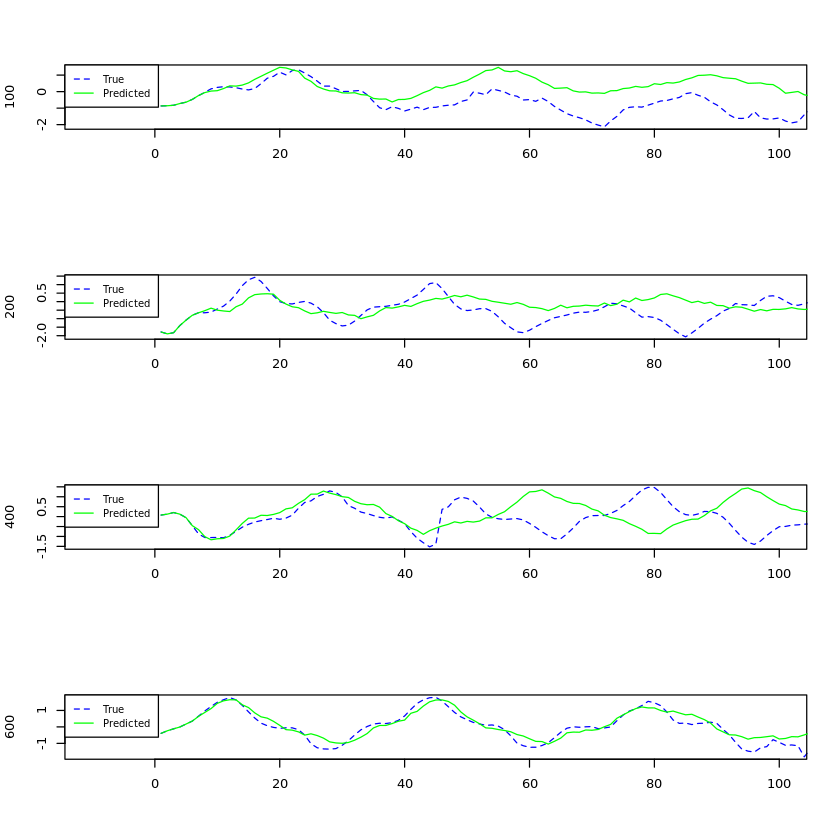

In [12]:
#plot first dimension of each sequence
par(mfrow = c(length(data_idx) ,1));
for (i in 1:length(data_idx))
{
    start <- data_idx[i];
    
    plot.true <- batchdata[(start - crbm$delay):(start + 100), 2];
    plot.pred <- generated_series[i,, 2];

    plot(plot.true, col = "blue", type = "l", lty = 2, xlab = "", ylab = data_idx[i], xlim = c(-10,100), ylim = c(min(plot.true, plot.pred),max(plot.true, plot.pred)));
    lines(plot.pred, col = "green");
    legend("topleft", legend = c("True", "Predicted"), col = c("blue","green"), lty = c(2,1), cex = 0.75, y.intersp = 1);
}